In [101]:
import numpy as np
import pandas as pd

from sklearn import linear_model, metrics, preprocessing, pipeline  # pip3 install sklearn --user
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

FIGSIZE = 16,4

In [3]:
dataset = pd.read_excel("../datasets/DB01_gaming_video_quality_dataset.xlsx")

### Task 1: Calculate MOS values

In [13]:
mos_by_game_condition = dataset.groupby(["Game", "Condition"]).mean()
mos_by_game_condition

PID  Resolution  Framerate  Bitrate        VQ        VF  \
Game  Condition                                                             
Game1 4          13.0       720.0       30.0   1000.0  2.948000  2.796000   
      5          13.0      1080.0       30.0   4000.0  4.112000  3.760000   
      15         13.0       480.0       30.0    300.0  1.988000  2.232000   
      19         13.0       480.0       60.0   2000.0  3.068000  3.724000   
      25         13.0       720.0       60.0  50000.0  5.080000  5.340000   
...               ...         ...        ...      ...       ...       ...   
Game6 71         11.5       480.0       30.0   2000.0  3.377273  4.486364   
      74         11.5       720.0       30.0   2000.0  3.777273  3.572727   
      77         11.5      1080.0       30.0  50000.0  5.013636  5.204545   
      78         11.5      1080.0       60.0  50000.0  5.450000  5.522727   
      80         11.5       720.0       30.0  50000.0  4.840909  5.240909   

                       VU        VD        AC        Age  Expertise  
Game  Condition                                                      
Game1 4          3.204000  4.840000  0.200000  23.875000   3.125000  
      5          4.392000  4.924000  0.640000  23.875000   3.125000  
      15         2.260000  5.092000  0.000000  23.875000   3.125000  
      19         2.876000  5.092000  0.160000  23.875000   3.125000  
      25         4.544000  5.536000  0.920000  23.875000   3.125000  
...                   ...       ...       ...        ...        ...  
Game6 71         3.027273  4.931818  0.181818  24.863636   3.181818  
      74         3.877273  4.822727  0.500000  24.863636   3.181818  
      77         5.209091  4.936364  0.818182  24.863636   3.181818  
      78         5.818182  5.336364  0.909091  24.863636   3.181818  
      80         5.100000  4.795455  0.681818  24.863636   3.181818  

[144 rows x 11 columns]

### Task 2: Calculate a new parameter called bitperpixel

In [21]:
num_pixels = {
    480: 720 * 480,
    720: 1280 * 720,
    1080: 1920 * 1080
}

def count_pixels(resolution):
    return num_pixels[int(resolution)]

mos_by_game_condition["num_pixels"] = mos_by_game_condition.Resolution.transform(count_pixels)
mos_by_game_condition["bitperpixel"] = mos_by_game_condition.Bitrate / mos_by_game_condition.num_pixels

### Task 3: Multiple linear regression

In [68]:
X = mos_by_game_condition[["VF", "VU", "VD"]].values
y = mos_by_game_condition[["VQ"]].values

model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

RMSE=0.15037739916835693
R^2=0.9754794697815228


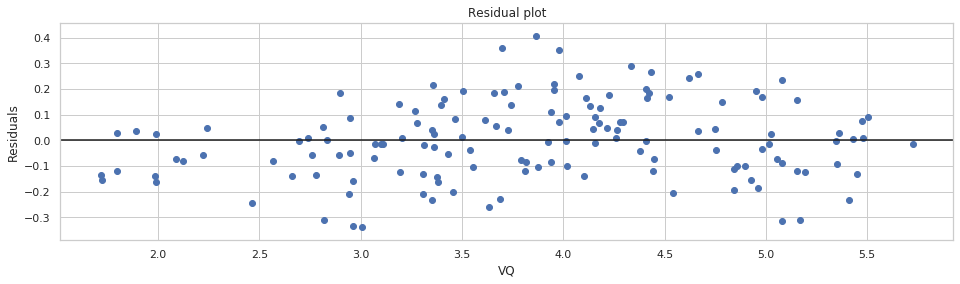

In [79]:
prediction = model.predict(X)
residuals = y - prediction

# Residual plot

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(y, residuals)

padding = 0.2
min_x = y.min() - padding
max_x = y.max() + padding
ax.hlines(0, min_x, max_x)
ax.set_xlim([min_x, max_x])

ax.set_title("Residual plot")
ax.set_ylabel("Residuals")
ax.set_xlabel("VQ")

# Report results

MSE = (residuals ** 2).mean()
RMSE = np.sqrt(MSE)
print(f"RMSE={RMSE}")

r2 = metrics.r2_score(y, prediction)
print(f"R^2={r_squared}")

### Task 4: Non-linear regressions

Fitted function: 7520.232533640273 * exp(--0.006079687647777501 * x) + -7516.537820364376


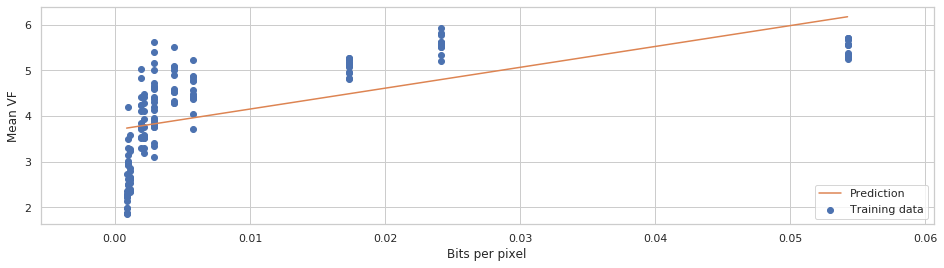

In [143]:
X = mos_by_game_condition.bitperpixel.values
y = mos_by_game_condition.VF.values

def exponential(x, a, b, c):
    """From https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html"""
    return a * np.exp(-b * x) + c

popt, pcov = optimize.curve_fit(exponential, X, y)
a, b, c = popt
print(f"Fitted function: {a} * exp(-{b} * x) + {c}")

X_predict = np.linspace(np.min(X), np.max(X))
y_predict = exponential(X_predict, *popt)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(X, y, label="Training data")
ax.plot(X_predict, y_predict, c="C1", label="Prediction")
ax.set_xlabel("Bits per pixel")
ax.set_ylabel("Mean VF")
ax.legend()

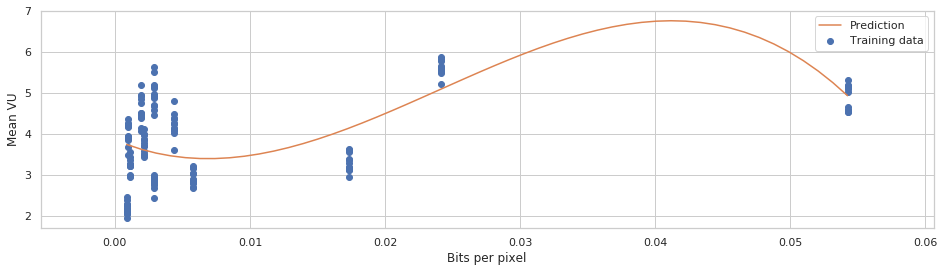

In [132]:
X = mos_by_game_condition[["bitperpixel"]].values
y = mos_by_game_condition[["VU"]].values

model = pipeline.make_pipeline(
    preprocessing.PolynomialFeatures(degree=3), linear_model.LinearRegression()
)
model.fit(X, y)

X_predict = np.linspace(np.min(X), np.max(X)).reshape(-1, 1)
y_predict = model.predict(X_predict)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(X, y, label="Training data")
ax.plot(X_predict, y_predict, c="C1", label="Prediction")
ax.set_xlabel("Bits per pixel")
ax.set_ylabel("Mean VU")
ax.legend()

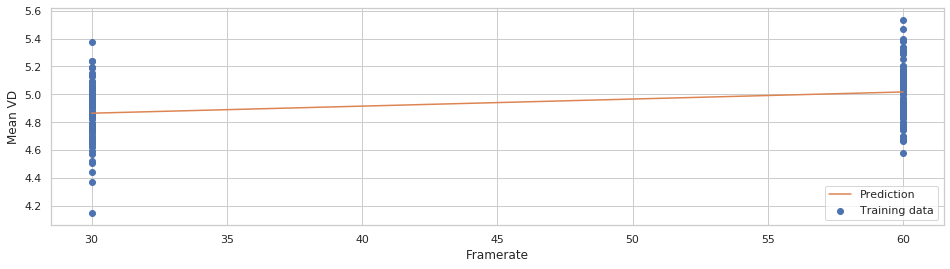

In [150]:
X = mos_by_game_condition.Framerate.values.reshape(-1, 1)
y = mos_by_game_condition.VD.values.reshape(-1, 1)

model = linear_model.LinearRegression()
model.fit(X, y)

X_predict = np.array([30, 60]).reshape(-1, 1)
y_predict = model.predict(X_predict)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(X, y, label="Training data")
ax.plot(X_predict, y_predict, c="C1", label="Prediction")
ax.set_xlabel("Framerate")
ax.set_ylabel("Mean VD")
ax.legend()